# Relax Inc Take Home Challenge

Relax Inc. makes productivity and project management software that's popular with both individuals and teams. \
The data is available as two attached CSV files: takehome_user_engagement.csv, takehome_users.csv \
The data has the following two tables:
1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years.
2. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption.

In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
#users = users.set_index('object_id')
print(users.head())
engage = pd.read_csv('takehome_user_engagement.csv',encoding = "ISO-8859-1")
print(engage.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [3]:
# adopted user, 0 - not adopted, 1 - adopted
usage = engage.groupby(['user_id']).size().reset_index().rename(columns={0:'count'})
usage['adopted'] = usage['count']>=3
adopted_users = list(usage[usage.adopted==1].user_id.unique())
users['adopted_users'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

print(users.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [4]:
# join two tables
df = engage.merge(users, left_on='user_id', right_on='object_id', how='outer')
print(df.head())

            time_stamp  user_id  visited  object_id        creation_time  \
0  2014-04-22 03:53:30      1.0      1.0          1  2014-04-22 03:53:30   
1  2013-11-15 03:45:04      2.0      1.0          2  2013-11-15 03:45:04   
2  2013-11-29 03:45:04      2.0      1.0          2  2013-11-15 03:45:04   
3  2013-12-09 03:45:04      2.0      1.0          2  2013-11-15 03:45:04   
4  2013-12-25 03:45:04      2.0      1.0          2  2013-11-15 03:45:04   

             name                     email creation_source  \
0  Clausen August  AugustCClausen@yahoo.com    GUEST_INVITE   
1   Poole Matthew    MatthewPoole@gustr.com      ORG_INVITE   
2   Poole Matthew    MatthewPoole@gustr.com      ORG_INVITE   
3   Poole Matthew    MatthewPoole@gustr.com      ORG_INVITE   
4   Poole Matthew    MatthewPoole@gustr.com      ORG_INVITE   

   last_session_creation_time  opted_in_to_mailing_list  \
0                1.398139e+09                         1   
1                1.396238e+09                 

#### Data Cleaning, Feature Engineering

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   time_stamp                  207917 non-null  object 
 1   user_id                     207917 non-null  float64
 2   visited                     207917 non-null  float64
 3   object_id                   211094 non-null  int64  
 4   creation_time               211094 non-null  object 
 5   name                        211094 non-null  object 
 6   email                       211094 non-null  object 
 7   creation_source             211094 non-null  object 
 8   last_session_creation_time  207917 non-null  float64
 9   opted_in_to_mailing_list    211094 non-null  int64  
 10  enabled_for_marketing_drip  211094 non-null  int64  
 11  org_id                      211094 non-null  int64  
 12  invited_by_user_id          118528 non-null  float64
 13  adopted_users 

In [6]:
df.describe()

,user_id,visited,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users
count,207917.000000,207917.0,211094.000000,2.079170e+05,211094.000000,211094.000000,211094.000000,118528.000000,211094.000000
mean,5913.314197,1.0,5913.818777,1.399439e+09,0.257890,0.154344,163.949558,5971.333347,0.952192
std,3394.941674,0.0,3395.988763,8.294017e+06,0.437474,0.361279,121.240661,3248.588044,0.213360
min,1.000000,1.0,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3087.000000,1.0,3081.000000,1.401045e+09,0.000000,0.000000,60.000000,3269.000000,1.000000
50%,5682.000000,1.0,5685.000000,1.401665e+09,0.000000,0.000000,145.000000,5972.000000,1.000000
75%,8944.000000,1.0,8944.000000,1.401868e+09,1.000000,0.000000,260.000000,8513.000000,1.000000
max,12000.000000,1.0,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


In [7]:
# 'visited' column has only one value
# delete duplicate columns 
del df['object_id'], df['visited']

In [8]:
# fill invited_by_user_id with 0 if not invited by anyone
df['invited_by_user_id'] = df['invited_by_user_id'].replace(np.nan, 0)

In [9]:
# drop NAs
df = df.dropna()

In [10]:
# data types
df['user_id'] = df['user_id'].astype(int)
df['invited_by_user_id'] = df['invited_by_user_id'].astype(int)

In [11]:
# datetimes
df['creation_time'] = pd.to_datetime(df['creation_time'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [12]:
df['creation_year'] = df['creation_time'].dt.year
df['creation_month'] = df['creation_time'].dt.month
df['creation_week'] = df['creation_time'].dt.week
df['creation_day'] = df['creation_time'].dt.day
df['creation_hour'] = df['creation_time'].dt.hour
df['creation_min'] = df['creation_time'].dt.minute
df['creation_dayweek'] = df['creation_time'].dt.dayofweek

df['stamp_year'] = df['time_stamp'].dt.year
df['stamp_month'] = df['time_stamp'].dt.month
df['stamp_week'] = df['time_stamp'].dt.week
df['stamp_day'] = df['time_stamp'].dt.day
df['stamp_hour'] = df['time_stamp'].dt.hour
df['stamp_min'] = df['time_stamp'].dt.minute
df['stamp_dayweek'] = df['time_stamp'].dt.dayofweek

In [14]:
# we may drop emails and names because these are personal information that does not affect user adoption much
df = df.drop(['name','email'],axis=1)

In [15]:
# some feature engineering
from sklearn.preprocessing import LabelEncoder
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [18]:
# delete some columns
df = df.drop(['time_stamp','creation_time'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     207917 non-null  int64  
 1   creation_source             207917 non-null  int64  
 2   last_session_creation_time  207917 non-null  float64
 3   opted_in_to_mailing_list    207917 non-null  int64  
 4   enabled_for_marketing_drip  207917 non-null  int64  
 5   org_id                      207917 non-null  int64  
 6   invited_by_user_id          207917 non-null  int64  
 7   adopted_users               207917 non-null  int64  
 8   creation_year               207917 non-null  int64  
 9   creation_month              207917 non-null  int64  
 10  creation_week               207917 non-null  int64  
 11  creation_day                207917 non-null  int64  
 12  creation_hour               207917 non-null  int64  
 13  creation_min  

#### EDA

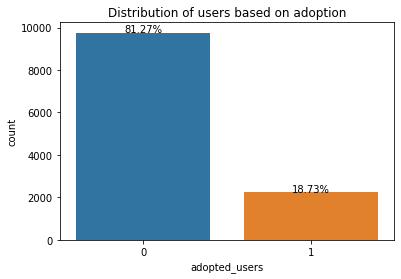

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
g1 = sns.countplot(x='adopted_users', data=users)
g1.set_title('Distribution of users based on adoption')

total = float(len(users))
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10)

81.27% of users do not adopt the product.

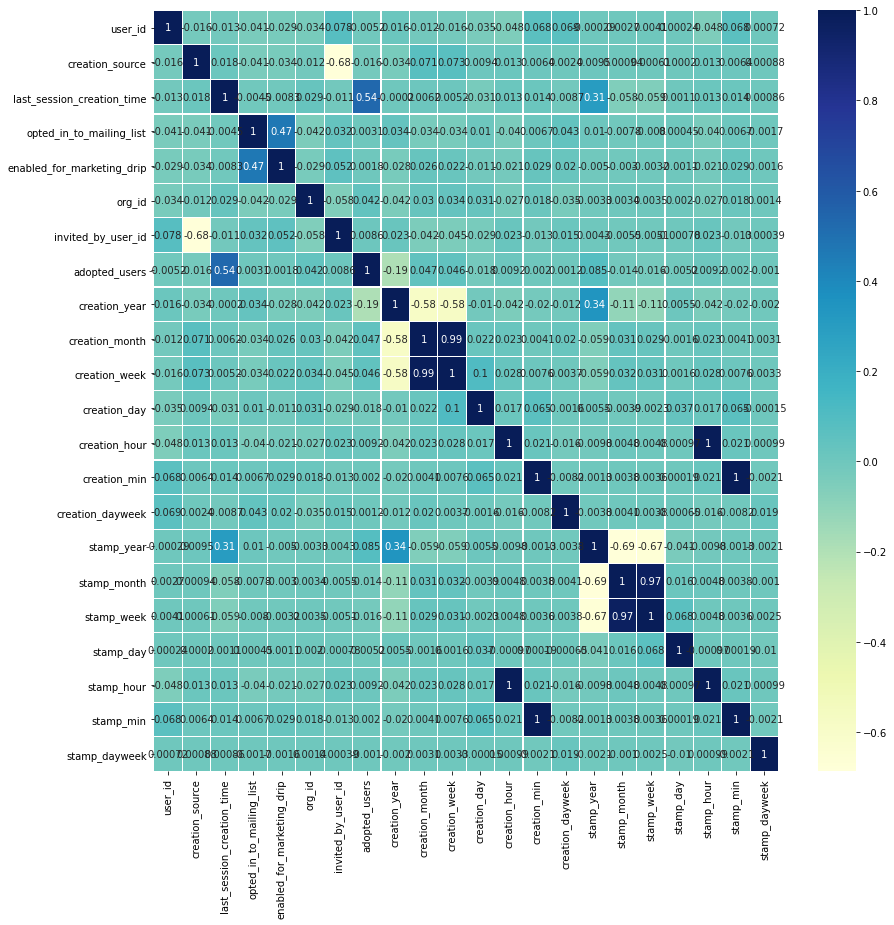

In [25]:
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

In [28]:
#Calculate the correlation coefficients
corr = df.corr()
drop = (corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
to_drop = corr.loc[drop, drop]
print(to_drop.columns.tolist())

['creation_month', 'creation_week', 'creation_hour', 'creation_min', 'stamp_month', 'stamp_week', 'stamp_hour', 'stamp_min']


In [30]:
df = df.drop(to_drop, axis=1)
print(df.head())

   user_id  creation_source  last_session_creation_time  \
0        1                0                1.398139e+09   
1        2                1                1.396238e+09   
2        2                1                1.396238e+09   
3        2                1                1.396238e+09   
4        2                1                1.396238e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0       1   
3                         0                           0       1   
4                         0                           0       1   

   invited_by_user_id  adopted_users  creation_year  creation_day  \
0               10803              0           2014            22   
1                 316              1           2013            15   
2                 316              

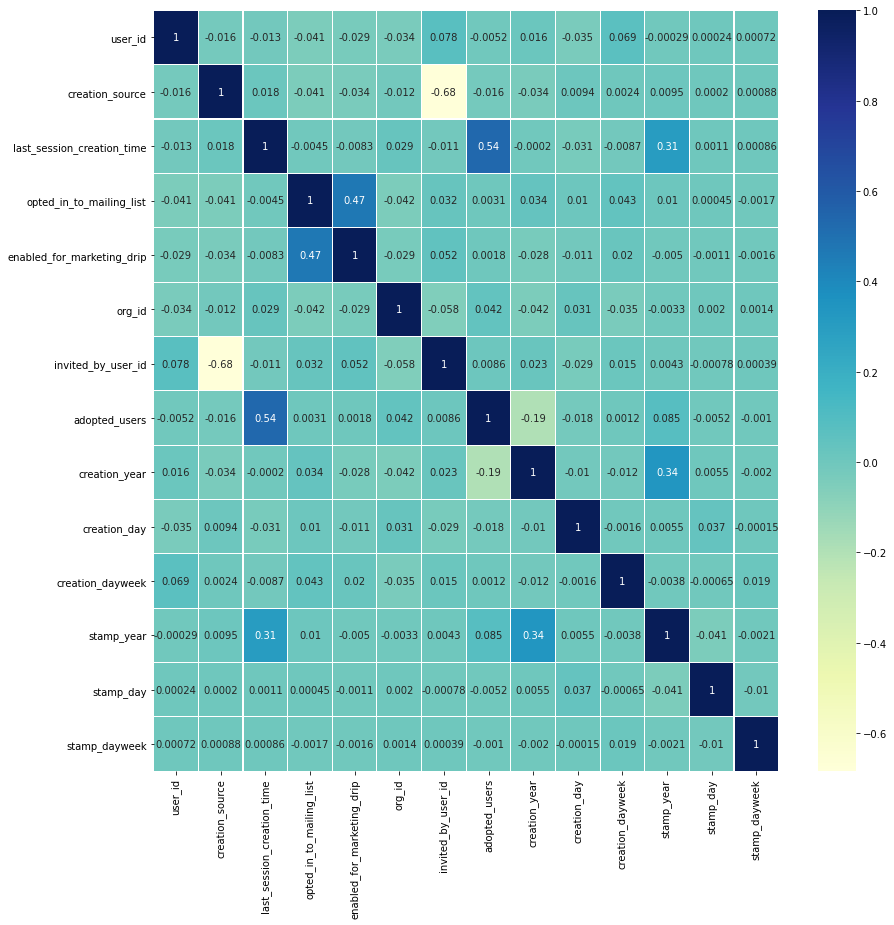

In [45]:
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

#### Preprocessing and Modelling

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [46]:
X = df.drop(['adopted_users', 'user_id'], axis=1)
y = df['adopted_users']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1399
           1       0.97      1.00      0.98     40185

    accuracy                           0.97     41584
   macro avg       0.48      0.50      0.49     41584
weighted avg       0.93      0.97      0.95     41584



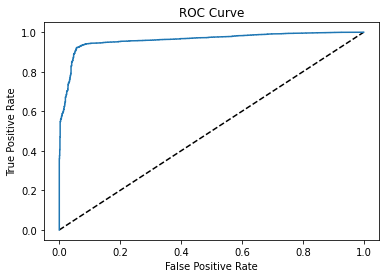

In [47]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_prob = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [48]:
# model score
print(lr.score(X_test,y_test))

# cross validation scores
print(np.mean(cross_val_score(lr,X_test,np.ravel(y_test),cv=5)))

0.9663572527895344
0.9663572550250439


              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1399
           1       1.00      1.00      1.00     40185

    accuracy                           1.00     41584
   macro avg       0.98      0.98      0.98     41584
weighted avg       1.00      1.00      1.00     41584



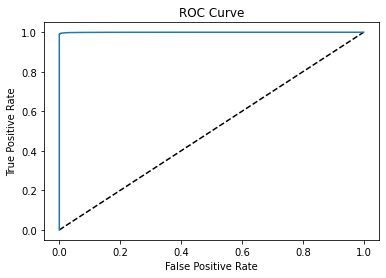

CPU times: user 23 s, sys: 436 ms, total: 23.4 s
Wall time: 8.01 s


In [49]:
%%time
rfc = RandomForestClassifier(n_estimators=100, random_state = 123, max_features = 'log2',  n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred2 = rfc.predict(X_test)

print(classification_report(y_test, y_pred2))

y_pred_prob2 = rfc.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [50]:
print(np.mean(cross_val_score(lr,X_test,np.ravel(y_test),cv=5)))

0.9663572550250439


12


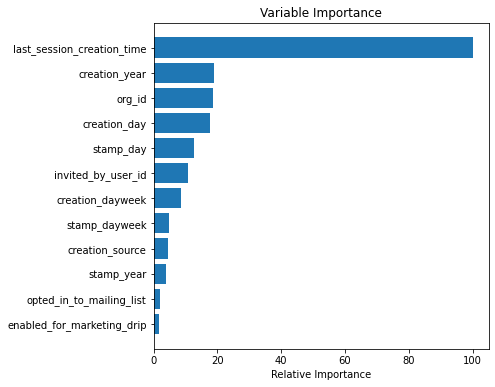

In [51]:
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(6,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Based on Random Forest Model, we can see that last_session_creation_time is the most important factor that predicts future user adoption.